# Quantinuum Hybrid Compute via pytket

This notebook contains an example of how to create and run hybrid classical-quantum workflows within the Quantinuum stack via `pytket`. 

**Note:** This notebook uses existing Wasm examples provided in this folder's subdirectories. To create and run your own Wasm functions, you'll need to set up an environment on your machine to support this workflow. Instructions for how to do this are given in this folder's README. 

* [Repeat Until Success](#repeat-until-success)

## Repeat Until Success <a class="anchor" id="repeat-until-success"></a>

This is a simple example made of how you can process measurements, using classical logic via Wasm, to implement a quantum loop, or a repeat-until-success (RUS) style circuit, also called an exit-on-failure circuit.

* [1 RUS Circuit](#1-rus-circuit)
* [RUS Experiment](#rus-experiment)

### 1 RUS Circuit <a class="anchor" id="1-rus-circuit"></a>

#### Import libraries

Note the `wasm` module imported from `pytket` as well as several several conditional operators that are options. More information on the conditional operations available can be found in the user manual at [Classical and Conditional Operations](https://cqcl.github.io/pytket/manual/manual_circuit.html#classical-and-conditional-operations).

In [1]:
import pathlib 

from pytket import wasm

from pytket.circuit import (
    Circuit, BitRegister, Qubit, OpType,
    if_bit, if_not_bit,
    reg_eq, reg_geq, reg_gt, reg_leq, reg_lt, reg_neq
)

from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend

#### Select Device

Select device and login to the Quantinuum API using your credentials.

In [2]:
machine = 'H1-1E'
backend = QuantinuumBackend(device_name=machine)
backend.login()

Enter your Quantinuum email: megan.l.kohagen@quantinuum.com
Enter your Quantinuum password: ········


#### Set up Circuit

Set up the RUS circuit. This involves 2 steps:
1. Set up Wasm File handler. This checks the Wasm file and can list the available functions within the file. 
2. Set up the pytket circuit, which calls the Wasm file handler.

In [3]:
rus_dir = pathlib.Path().cwd().joinpath('repeat_until_success')
wasm_file = rus_dir.joinpath('rus_wasm.wasm')
wfh = wasm.WasmFileHandler(wasm_file)

print(repr(wfh))

Functions in wasm file with the uid f63152fe288eb6dc9e9cf58f7a02194f:
function 'init' with 0 i32 parameter(s) and 0 i32 return value(s)
function 'add_count' with 2 i32 parameter(s) and 1 i32 return value(s)



In [4]:
def RUS(limit, cond_execute):
    """
    limit: number of attempts
    cond_execute: condition to execute, i.e. run this until a total of cond_execute |1> measurements is achieved.
    
    """
    # Create circuit with two qubits
    circuit = Circuit(2, name=f"RUS_limit={limit}_cond={cond_execute}")

    # Add classical registers
    creg0 = circuit.add_c_register("creg0", 1)
    creg1 = circuit.add_c_register("creg1", 1)
    cond = circuit.add_c_register("cond", 32)
    count = circuit.add_c_register("count", 32)

    # Set cond to 0
    circuit.add_c_setreg(0, cond)

    # Loops
    for loop_iter in range(1, limit+1):
        
        circuit.H(0, condition=reg_lt(cond, cond_execute))
        circuit.CX(0, 1, condition=reg_lt(cond, cond_execute))
        circuit.Measure(Qubit(1), creg1[0], condition=reg_lt(cond, cond_execute))
        
        # Add wasm call with the parameters creg1 and count, writing the result to cond
        # The function "add_count" is used from the Wasm file
        circuit.add_wasm_to_reg("add_count", wfh, [creg1, count], [cond], condition=reg_lt(cond, cond_execute))
        
        circuit.add_c_setreg(loop_iter, count, condition=reg_lt(cond, cond_execute))
        circuit.add_gate(OpType.Reset, [0], condition=reg_lt(cond, cond_execute))

    circuit.Measure(Qubit(0), creg0[0])
    circuit.Measure(Qubit(1), creg1[0])
    
    return circuit

Set up the circuit.

In [5]:
circuit = RUS(5, 3)

render_circuit_jupyter(circuit)

#### Circuit Compilation

`pytket` includes many features for optimizing circuits. This includes reducing the number of gates where possible and resynthesizing circuits for a quantum computer's native gate set. See the `pytket` [User Manual](https://cqcl.github.io/pytket/manual/index.html) for more information on all the options that are available.

Here the circuit is compiled with `get_compiled_circuit`, which includes optimizing the gates and resynthesizing the circuit to Quantinuum's native gate set. The `optimisation_level` sets the level of optimisation to perform during compilation, check `pytket-quantinuum` documentation for more information, specifically the [Default Compilation](https://cqcl.github.io/pytket-quantinuum/api/index.html#default-compilation) section.

In [6]:
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=0)

render_circuit_jupyter(compiled_circuit)

#### Check Circuit Cost

Check the cost of the experiment before running.

In [7]:
n_shots = 1000
backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker='H1-1SC')

39.0

#### Submit and Run the Circuit

Note the `wasm_file_handler` input in the `process_circuit` function. This ensures the Wasm functions are passed onto the Quantinuum API.

In [8]:
handle = backend.process_circuit(compiled_circuit, 
                                 n_shots=n_shots,
                                 wasm_file_handler=wfh)
print(handle)

('1cb0b79000db4c9aa911f9ba82af2cac', 'null')


In [9]:
status = backend.circuit_status(handle)
print(status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "RUS_limit=5_cond=3", "submit-date": "2023-02-28T17:48:37.047615", "result-date": "2023-02-28T17:49:46.510025", "queue-position": null, "cost": "39", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [10]:
result = backend.get_result(handle)

result

BackendResult(q_bits={},c_bits={creg1[0]: 0, creg0[0]: 1, count[31]: 2, count[30]: 3, count[29]: 4, count[28]: 5, count[27]: 6, count[26]: 7, count[25]: 8, count[24]: 9, count[23]: 10, count[22]: 11, count[21]: 12, count[20]: 13, count[19]: 14, count[18]: 15, count[17]: 16, count[16]: 17, count[15]: 18, count[14]: 19, count[13]: 20, count[12]: 21, count[11]: 22, count[10]: 23, count[9]: 24, count[8]: 25, count[7]: 26, count[6]: 27, count[5]: 28, count[4]: 29, count[3]: 30, count[2]: 31, count[1]: 32, count[0]: 33, cond[31]: 34, cond[30]: 35, cond[29]: 36, cond[28]: 37, cond[27]: 38, cond[26]: 39, cond[25]: 40, cond[24]: 41, cond[23]: 42, cond[22]: 43, cond[21]: 44, cond[20]: 45, cond[19]: 46, cond[18]: 47, cond[17]: 48, cond[16]: 49, cond[15]: 50, cond[14]: 51, cond[13]: 52, cond[12]: 53, cond[11]: 54, cond[10]: 55, cond[9]: 56, cond[8]: 57, cond[7]: 58, cond[6]: 59, cond[5]: 60, cond[4]: 61, cond[3]: 62, cond[2]: 63, cond[1]: 64, cond[0]: 65},counts=None,shots=[[128   0   0 ...   0   

In [ ]:
import json

with open(compiled_circuit.name+'.json', 'w') as file:
    json.dump(result.to_dict(), file)

#### Analyze Results

Define a function to analyze the counts of 0 and 1 measurements on the `creg1` register.

In [11]:
def analyze_RUS_experiment(result: dict):
    """ Analyze results of RUS experiment. 
    
        resutl: list type
    """
    creg1_0_cnts = {}
    creg1_1_cnts = {}

    for k, res in result.items():

        # Retrieve which c_bit corresponds to creg1 for this result
        creg1 = [x for x in res.c_bits.keys() if x.reg_name == 'creg1'][0]

        # Retrieve the creg1 results for that experiment
        result_creg1 = [x[res.c_bits[creg1]] for x in res.get_shots()]

        # Retrieve n_shots for that experiment
        n_shots = len(res.get_shots())

        # Retrieve limit and cond for that experiment
        limit = int(k[k.find('limit=')+6:k.find('_cond=')])
        cond = int(k[k.find('_cond=')+6:])

        # Store results
        creg1_0_cnts[limit, cond] = [result_creg1.count(0), result_creg1.count(0)/n_shots]
        creg1_1_cnts[limit, cond] = [result_creg1.count(1), result_creg1.count(1)/n_shots]
        
    return creg1_0_cnts, creg1_1_cnts

In [12]:
result1 = {}
result1[compiled_circuit.name] = result
creg1_0_cnts, creg1_1_cnts = analyze_RUS_experiment(result1)

Results of 0 counts on the `creg1` register.

In [13]:
creg1_0_cnts

{(5, 3): [170, 0.17]}

### RUS Experiment <a class="anchor" id="rus-experiment"></a>

A more interesting experiment is to experiment with what happens with different values of the `limit`. The function below submits a set of RUS experiments using the `pytket-quantinuum` batch feature.

In [14]:
def rus_experiment(limit_start, limit_end, cond_execute, machine, n_shots, max_batch_cost=500, 
                   check_cost=True, run_exp=False):
    """ Function for running a series of RUS experiments. """
    experiment_cost = []
    batch_handles = {}

    backend = QuantinuumBackend(device_name=machine)

    for limit in range(limit_start, limit_end+1):

        circuit = RUS(limit, cond_execute)
        compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=0)

        if check_cost:
            circuit_cost = None
            while circuit_cost is None:
                circuit_cost = backend.cost(compiled_circuit, n_shots=n_shots, syntax_checker=machine.replace('E', 'SC'))
            experiment_cost.append(circuit_cost)

        if run_exp:
            if limit == limit_start:
                batch_start = backend.start_batch(max_batch_cost=max_batch_cost, circuit=compiled_circuit, n_shots=n_shots,
                                                  wasm_file_handler=wfh)
                batch_handles[compiled_circuit.name] = batch_start
            elif limit == limit_end:
                batch_end = backend.add_to_batch(batch_start, compiled_circuit, n_shots=n_shots, wasm_file_handler=wfh, 
                                                 batch_end=True)
                batch_handles[compiled_circuit.name] = batch_end
            else:
                batch_mid = backend.add_to_batch(batch_start, compiled_circuit, n_shots=n_shots, wasm_file_handler=wfh)
                batch_handles[compiled_circuit.name] = batch_mid
                
    return batch_handles, experiment_cost

Set up the experiment parameters.

In [19]:
machine = 'H1-1E'
n_shots = 1000
cond_execute = 3
limit_start = 1
limit_end = 20

Check the cost in HQCs for running the experiment before running.

In [20]:
batch_handles, experiment_cost = rus_experiment(limit_start, limit_end, cond_execute, machine, n_shots)
print("Total Experiment Cost:", sum(experiment_cost))

Total Experiment Cost: 1440.0


The total cost of the experiment with 1,000 shots each is greater than a max batch cost, but submitting in batch will keep the up to the max batch cost (500 HQCs) run together.

Submit the full set of experiments.

In [21]:
check_cost = False
run_exp = True
batch_handles, experiment_cost = rus_experiment(limit_start, limit_end, cond_execute, machine, n_shots,
                                                check_cost=check_cost, run_exp=run_exp)

Check the status of the jobs.

In [22]:
status_list = [backend.circuit_status(h) for k, h in batch_handles.items()]
num_completed = len([x for x in status_list if x.status.name == 'COMPLETED'])
print(f"{num_completed}/{len(status_list)} completed")

20/20 completed


Save results once completed, in case you need to come back to analysis later.

In [23]:
import json

result = {}
result_json = {}

for k, h in batch_handles.items():
    result[k] = backend.get_result(h)
    result_json[k] = backend.get_result(h).to_dict()

with open('RUS_experiments.json', 'w') as file:
    json.dump(result_json, file)

Load saved results, if coming back to the experiment results.

In [24]:
import json
from pytket.backends.backendresult import BackendResult

with open('RUS_experiments.json') as file:
    data = json.load(file)

result = {}
for k, h in data.items():
    result[k] = BackendResult.from_dict(h)

Analyze results. Here we count the number of 0 or 1 measurements on the `creg1` register.

In [25]:
creg1_0_cnts = {}
creg1_1_cnts = {}

for k, res in result.items():
    
    # Retrieve which c_bit corresponds to creg1 for this result
    creg1 = [x for x in res.c_bits.keys() if x.reg_name == 'creg1'][0]
    
    # Retrieve the creg1 results for that experiment
    result_creg1 = [x[res.c_bits[creg1]] for x in res.get_shots()]
    
    # Retrieve n_shots for that experiment
    n_shots = len(res.get_shots())
    
    # Retrieve limit and cond for that experiment
    limit = int(k[k.find('limit=')+6:k.find('_cond=')])
    cond = int(k[k.find('_cond=')+6:])
    
    # Store results
    creg1_0_cnts[limit, cond] = [result_creg1.count(0), result_creg1.count(0)/n_shots]
    creg1_1_cnts[limit, cond] = [result_creg1.count(1), result_creg1.count(1)/n_shots]

Plot results.

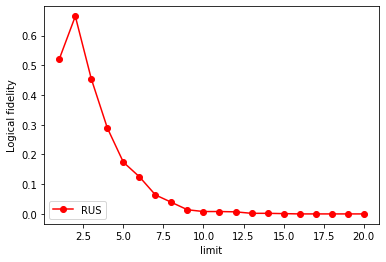

In [26]:
import matplotlib.pyplot as plt

plt.figure()

# Plot limit vs. Fidelity (Count of 0%)
plt.errorbar([k[0] for k, v in creg1_0_cnts.items()], 
             [v[1] for k, v in creg1_0_cnts.items()],
             yerr=None, label="RUS", marker='o', alpha=1.0, color='red')

plt.ylabel('Logical fidelity')
plt.xlabel('limit')
plt.legend(loc='lower left')
plt.show()

<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>